# Dynamic Feature Scaling Techniques for Time Series

### Project Understanding and Goal Definition

### Project Overview:

This project looks at how electricity prices change over time in France and its neighboring countries. I start by organizing our data and making sure it's clean and ready for analysis. Then, I explore the data to find any interesting patterns or trends. Next, I create new features from our data to help us predict future electricity prices more accurately. I use different types of computer programs to make these predictions, making sure to adjust the settings to get the best results.
I also combine different prediction methods to make our forecasts even better. Finally, I explain why electricity prices change using a method called SHAP values. This project is important because it helps businesses, researchers, and others understand and predict electricity prices. By knowing how prices might change, they can make better decisions about buying and selling electricity.

### About Dataset
This dataset provides hourly day ahead electricity prices for France and interconnections, sourced from the ENTSO-E Transparency Platform, which is a reputable market data provider for European electricity markets. It is valuable resource for businesses, investors, researchers, and energy consumers interested in analyzing and understanding the dynamics of the electricity market with a high level of granularity.

### What are Day Ahead Electricity Prices ?

Electricity day ahead prices refer to the prices at which electricity is bought and sold in the wholesale market for delivery the next day. These prices are determined through a process called day-ahead market (DAM) auctions, where electricity generators and suppliers submit bids and offers for the electricity they are willing to buy or sell for delivery the following day.

The day ahead prices are typically based on various factors such as supply and demand conditions, availability of generation sources (such as renewable energy, nuclear, or fossil fuel), weather conditions, and transmission constraints. These prices are determined through a competitive bidding process, where participants submit their bids and offers based on their expected costs and revenues. Electricity day ahead prices are important because they serve as a reference for pricing electricity contracts, setting wholesale electricity prices, and managing electricity supply and demand on a daily basis. They also influence retail electricity prices, as they can impact the cost of electricity for end consumers. In some regions, day ahead prices may also be used as a benchmark for other timeframes, such as intraday or real-time prices, which reflect more immediate changes in supply and demand. Understanding day ahead prices can be useful for electricity market participants, policymakers, and consumers to make informed decisions about their electricity usage, pricing strategies, and investment in electricity generation and consumption technologies

### Dataset Overview

The dataset includes historical and forecasted day ahead (DAH) electricity prices for France and interconnections (Germany, Italy, Spain, UK, Belgium). The data is presented at an hourly granularity, covering a specific timeframe, and includes information such as hourly electricity prices in Euros per MWh (Megawatt-hour), date, time. The dataset is presented in a structured format, such as CSV or Excel, making it easy to manipulate and analyze using various data analysis tools and techniques. It is ideal for conducting research, building predictive models, or gaining insights into the day ahead electricity prices for France and interconnections at an hourly level.

### Use Case Examples

*  Developing hourly price forecasting models for France using machine learning algorithms (Deep Learning, Regressions, Random Forests)
*  Analyzing the impact of cross-border electricity trading on hourly prices (EDA)
*  Studying historical hourly trends and patterns in electricity prices for France (Time Series Analysis, LSTM)
*  Building energy pricing models for business planning and strategy with hourly granularity
*  Conducting research on hourly energy market dynamics and trends




### Step 1: Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import warnings
# Suppress future warning for use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv("/kaggle/input/electricity-dayahead-prices-entsoe/electricity_dah_prices.csv")

### Step 2: Preprocessing

In [4]:
df.head()

,date,hour,france,italy,belgium,spain,uk,germany
0,2022/01/01,00:00 - 01:00,89.06,170.28,82.02,145.86,0.27,50.05
1,2022/01/01,01:00 - 02:00,78.48,155.72,67.07,114.90,-0.01,41.33
2,2022/01/01,02:00 - 03:00,85.16,147.09,75.11,113.87,0.27,43.22
3,2022/01/01,03:00 - 04:00,50.00,91.00,50.91,97.80,-0.01,45.46
4,2022/01/01,04:00 - 05:00,37.67,104.00,37.67,97.80,-0.01,37.67


In [5]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 date          0
hour          0
france        1
italy         1
belgium       1
spain         1
uk         1442
germany       1
dtype: int64


In [6]:
# Handle missing values by forward filling
df.ffill(inplace=True)  # Forward fill missing values

In [7]:
# Combine 'date' and 'hour' columns into a single timestamp column
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['hour'].str.split(' - ', expand=True)[0])

# Drop the 'date' and 'hour' columns if they are no longer needed
df.drop(['date', 'hour'], axis=1, inplace=True)

# Set the newly created 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Check the DataFrame after conversion
df.head()

,france,italy,belgium,spain,uk,germany
timestamp,,,,,,
2022-01-01 00:00:00,89.06,170.28,82.02,145.86,0.27,50.05
2022-01-01 01:00:00,78.48,155.72,67.07,114.90,-0.01,41.33
2022-01-01 02:00:00,85.16,147.09,75.11,113.87,0.27,43.22
2022-01-01 03:00:00,50.00,91.00,50.91,97.80,-0.01,45.46
2022-01-01 04:00:00,37.67,104.00,37.67,97.80,-0.01,37.67


In [8]:
# Convert timestamp to a specific timezone if necessary
df.index = df.index.tz_localize('UTC').tz_convert('Europe/Berlin')

In [9]:
# Check for outliers using Z-score and delete them
def remove_outliers(df, threshold=3):
    z_scores = df.apply(lambda x: np.abs((x - x.mean()) / x.std()))
    outliers = z_scores > threshold
    df[outliers] = np.nan  # Convert outliers to NaNs
    df.dropna(inplace=True)  # Drop rows with NaNs
    return df

# Apply noise removal function to our dataframe
df = remove_outliers(df)

In [10]:
# Check data types of columns
print("Data Types:\n", df.dtypes)

Data Types:
 france     float64
italy      float64
belgium    float64
spain      float64
uk         float64
germany    float64
dtype: object


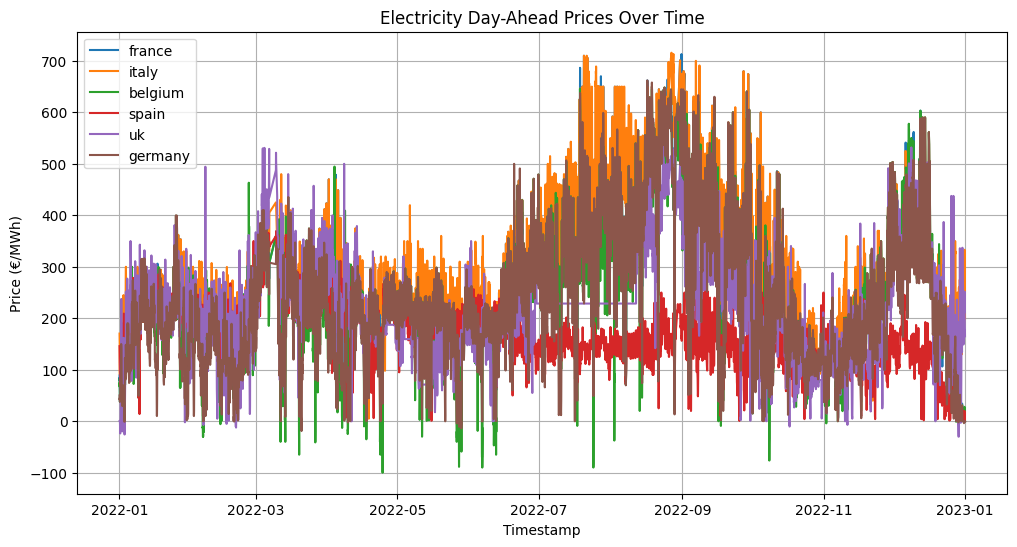

In [11]:
# Visualize temporal patterns in electricity prices for each country
plt.figure(figsize=(12, 6))
for country in df.columns:
    plt.plot(df.index, df[country], label=country)
plt.title('Electricity Day-Ahead Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

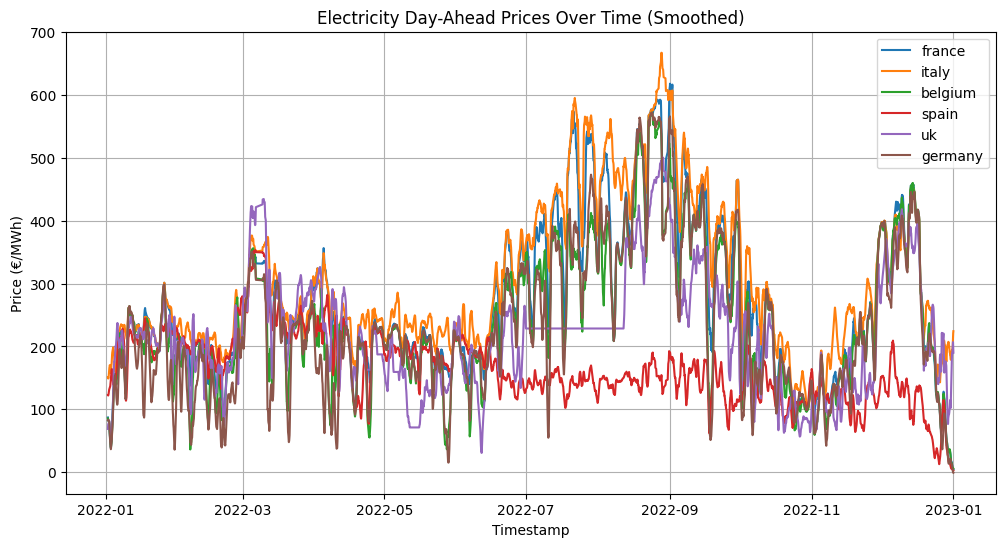

In [12]:
# Apply moving averages to smooth out the noise
window_size = 24  # Adjust the window size as needed
smoothed_df = df.rolling(window=window_size).mean()

# Visualize temporal patterns in electricity prices for each country
plt.figure(figsize=(12, 6))
for country in smoothed_df.columns:
    plt.plot(smoothed_df.index, smoothed_df[country], label=country)
plt.title('Electricity Day-Ahead Prices Over Time (Smoothed)')
plt.xlabel('Timestamp')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

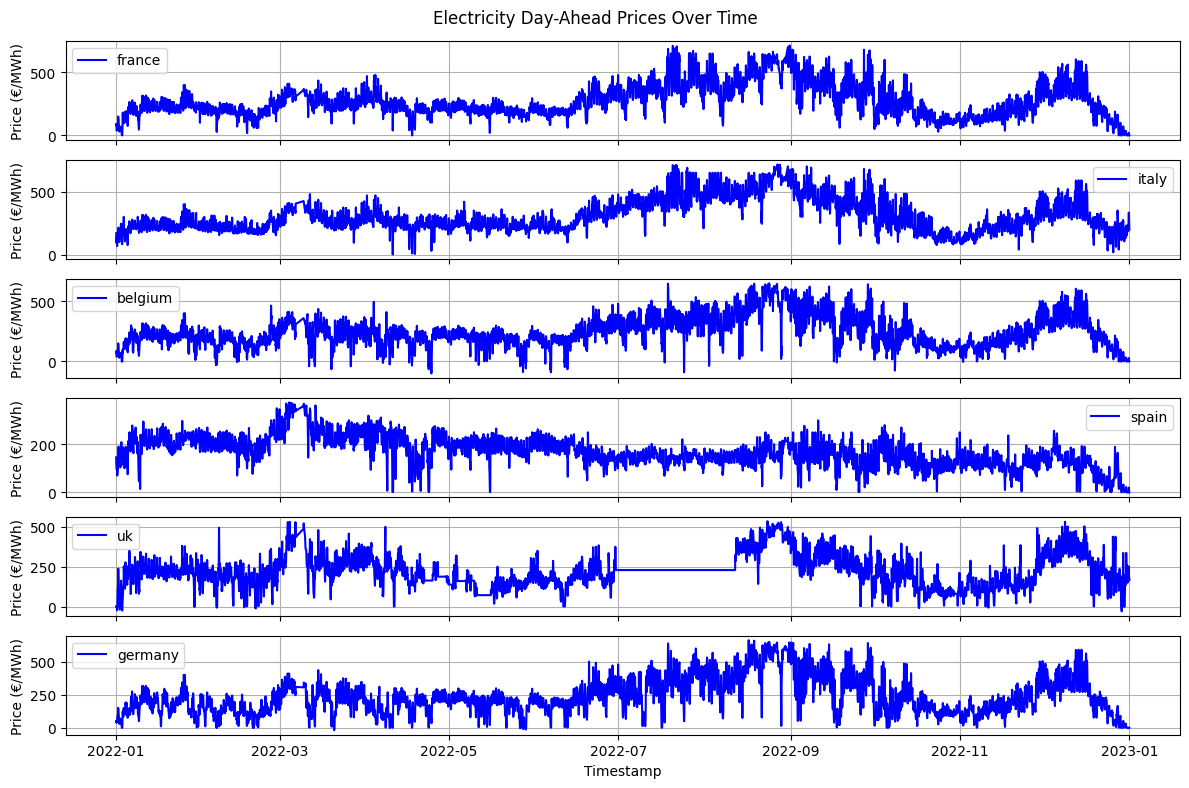

In [13]:
# Visualize temporal patterns in electricity prices for each country using subplots
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(12, 8), sharex=True)

for i, country in enumerate(df.columns):
    axes[i].plot(df.index, df[country], label=country, color='blue')
    axes[i].set_ylabel('Price (€/MWh)')
    axes[i].grid(True)
    axes[i].legend()

plt.xlabel('Timestamp')
plt.suptitle('Electricity Day-Ahead Prices Over Time')
plt.tight_layout()
plt.show()

### Step 3: Exploratory Data Analysis (EDA)

In [14]:
# Summary statistics
summary_stats = df.describe()
print(summary_stats)

            france        italy      belgium        spain           uk  \
count  8499.000000  8499.000000  8499.000000  8499.000000  8499.000000   
mean    265.328737   297.999555   235.238742   163.453466   212.411924   
std     127.663551   124.882571   122.871312    61.119893    95.392507   
min      -1.440000     1.000000  -100.000000     0.000000   -30.000000   
25%     180.950000   210.560000   155.360000   123.185000   151.000000   
50%     235.310000   262.380000   215.880000   161.990000   215.000000   
75%     335.045000   370.130000   303.360000   204.635000   258.935000   
max     713.200000   715.820000   648.000000   375.000000   535.060000   

           germany  
count  8499.000000  
mean    225.644365  
std     130.304206  
min     -19.040000  
25%     131.580000  
50%     204.770000  
75%     298.985000  
max     662.050000  


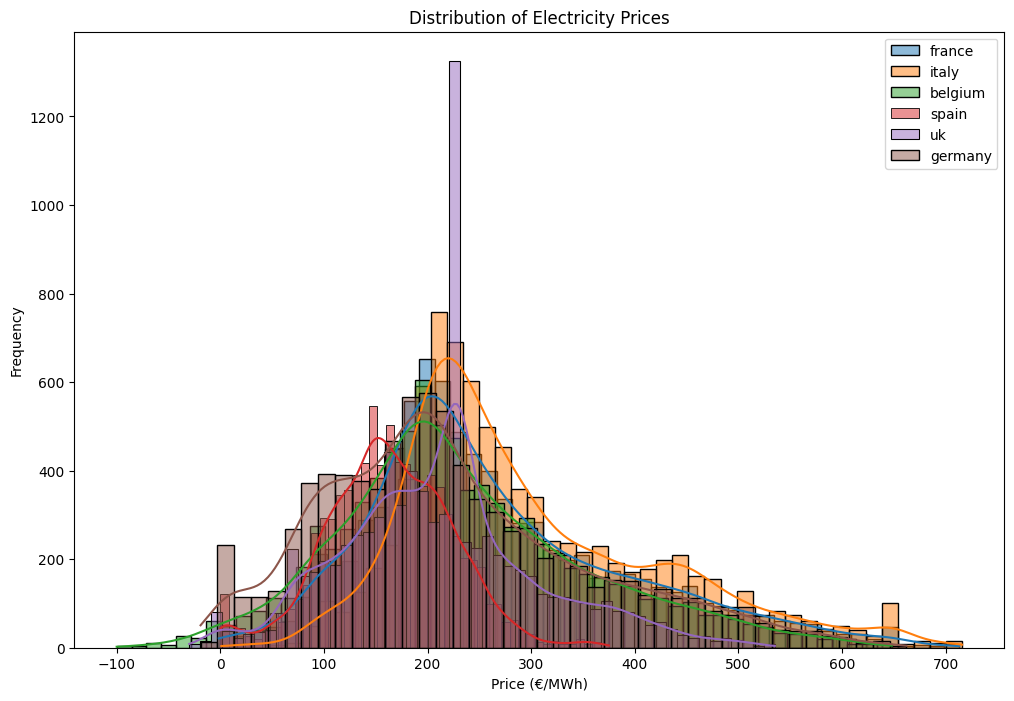

In [15]:
# Plot histograms
plt.figure(figsize=(12, 8))
for country in df.columns:
    sns.histplot(df[country], kde=True, label=country, alpha=0.5)
plt.title('Distribution of Electricity Prices')
plt.xlabel('Price (€/MWh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

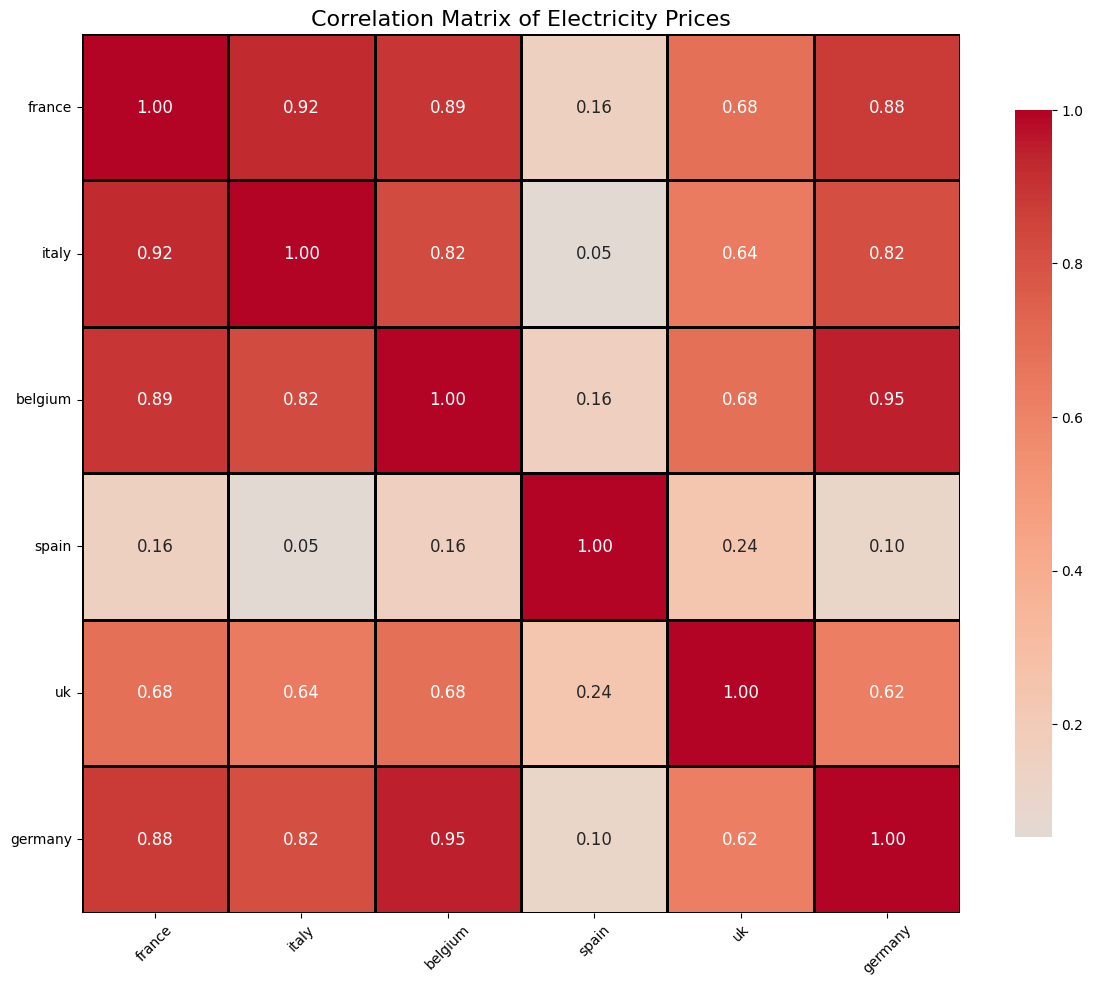

In [16]:
# Correlation matrix
corr_matrix = df.corr()

# Create a heatmap with customizations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=1, 
            linecolor='black', 
            square=True, 
            cbar_kws={"shrink": 0.8},
            annot_kws={"fontsize": 12},
            center=0)

plt.title('Correlation Matrix of Electricity Prices', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Step 4: Feature Engineering

In [17]:
# Create date-time features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

In [18]:
# Create lag features for existing columns
lag_periods = [1, 2, 3, 4, 5]  # Define lag periods
for column in df.columns:
    for lag in lag_periods:
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)

In [19]:
# Calculate rolling window statistics for existing columns
window_sizes = [3, 7, 14]  # Define window sizes
new_columns = []  # Store new column names
new_data = []  # Store new column data

for column in df.columns:
    if column != 'timestamp':  # Skip timestamp column if present
        for window in window_sizes:
            new_columns.append(f'{column}_mean_{window}')
            new_data.append(df[column].rolling(window).mean())
            new_columns.append(f'{column}_std_{window}')
            new_data.append(df[column].rolling(window).std())

# Concatenate new columns and data into a new DataFrame
new_df = pd.concat(new_data, axis=1, keys=new_columns)

# Combine with the original DataFrame
df = pd.concat([df, new_df], axis=1)

In [20]:
# Print columns of the DataFrame to verify its structure
print(df.columns)

# Check if the 'price' column exists in our DataFrame
if 'price' in df.columns:
    # Create lag features
    lag_periods = [1, 2, 3, 4, 5]  # Define lag periods
    for lag in lag_periods:
        df[f'price_lag_{lag}'] = df['price'].shift(lag)
else:
    print("The 'price' column does not exist in the DataFrame.")

Index(['france', 'italy', 'belgium', 'spain', 'uk', 'germany', 'year', 'month',
       'day', 'hour',
       ...
       'hour_lag_4_mean_7', 'hour_lag_4_std_7', 'hour_lag_4_mean_14',
       'hour_lag_4_std_14', 'hour_lag_5_mean_3', 'hour_lag_5_std_3',
       'hour_lag_5_mean_7', 'hour_lag_5_std_7', 'hour_lag_5_mean_14',
       'hour_lag_5_std_14'],
      dtype='object', length=420)
The 'price' column does not exist in the DataFrame.


In [21]:
# Identify or create the price column
# For example, if you have price information in multiple columns, you can create a new 'price' column by averaging the prices from these columns
df['price'] = df[['france', 'italy', 'belgium', 'spain', 'uk', 'germany']].mean(axis=1)

# Apply logarithmic transformation to the 'price' column
df['log_price'] = np.log1p(df['price'])

In [22]:
# Drop rows with NaN values
df.dropna(inplace=True)

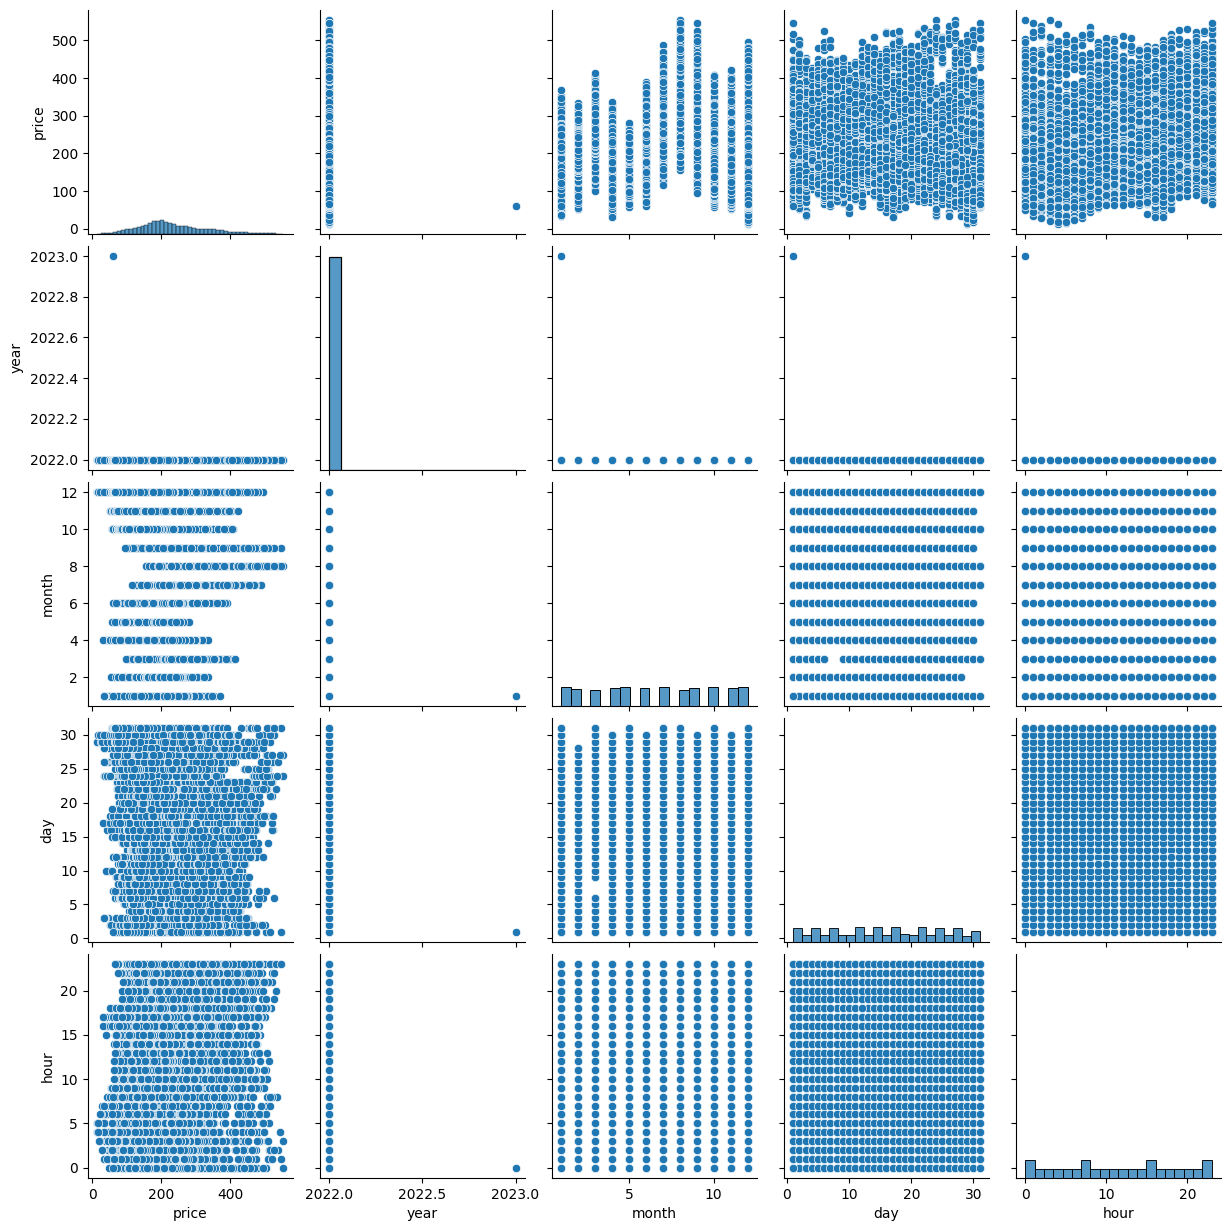

In [23]:
# Pairplot to visualize relationships between multiple variables
sns.pairplot(df[['price', 'year', 'month', 'day', 'hour']])
plt.show()

In [24]:
# Subset the data to include only relevant variables
subset_df = df[['price', 'year', 'month', 'day', 'hour']].sample(n=1000, random_state=42)  # Sample 1000 data points for clarity

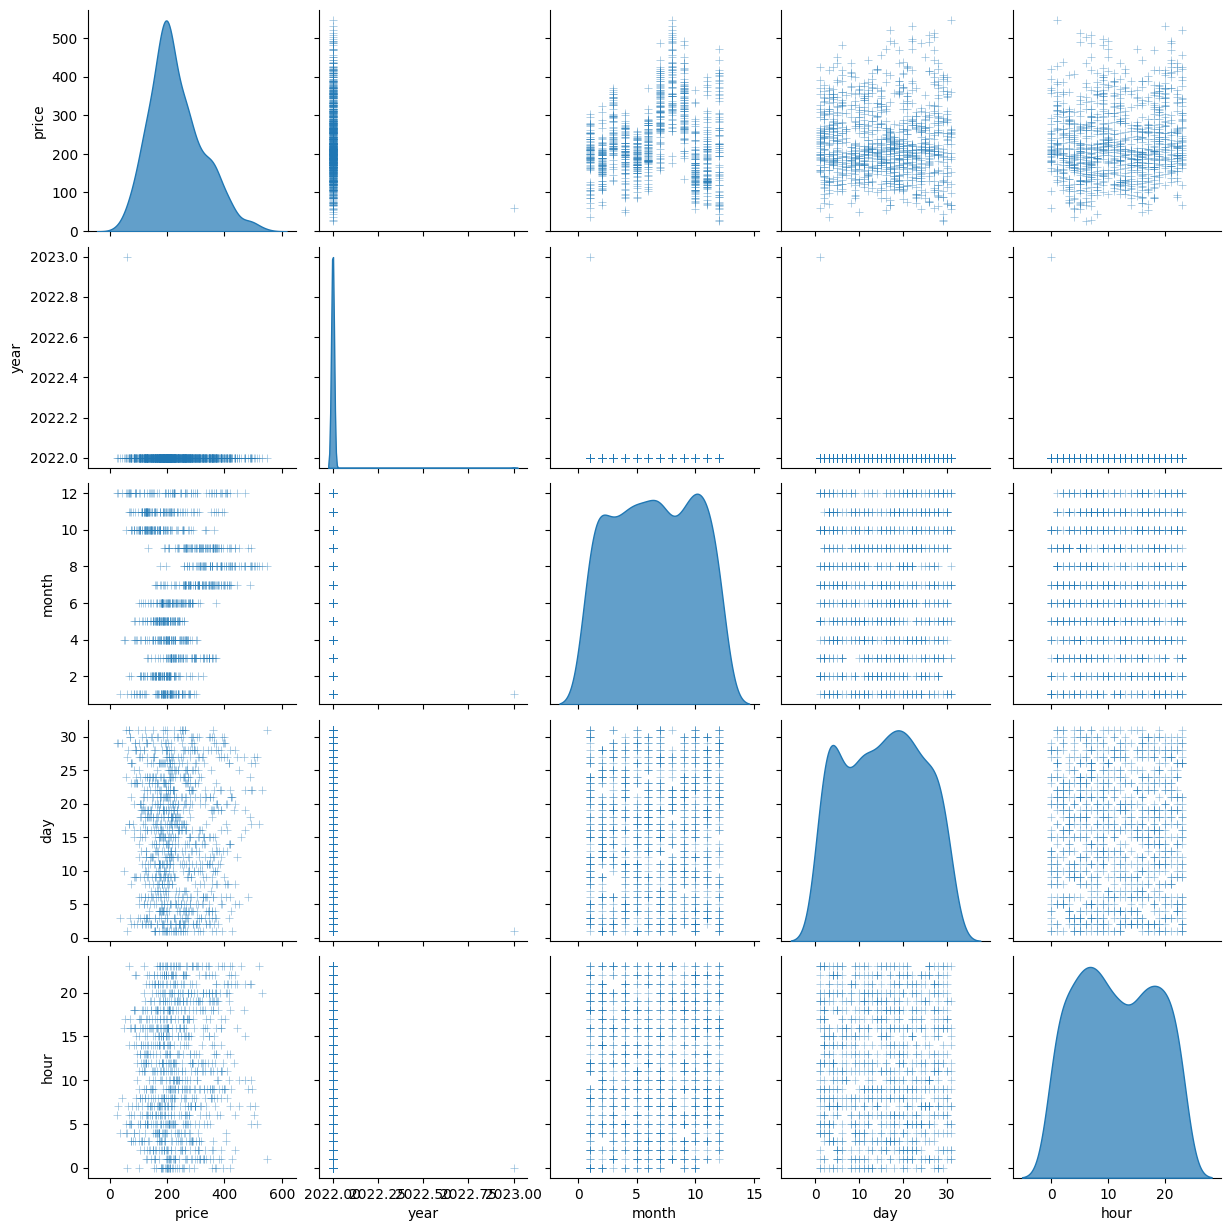

In [25]:
# Adjust plot parameters to reduce clutter
sns.pairplot(subset_df, diag_kind='kde', markers='+', plot_kws={'alpha': 0.5}, diag_kws={'alpha': 0.7})
plt.show()

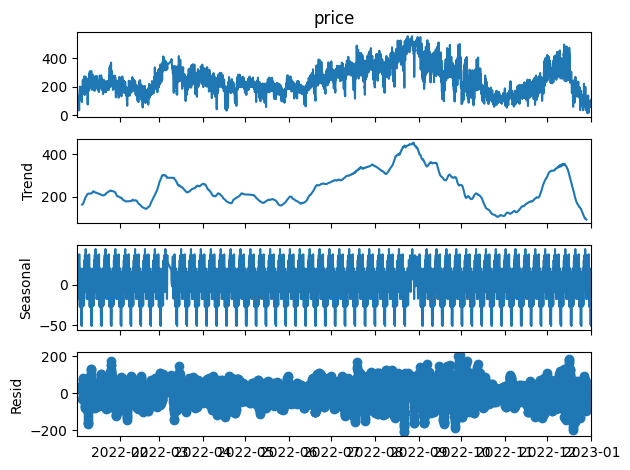

In [26]:
# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['price'], model='additive', period=24*7)  # Weekly seasonality
result.plot()
plt.show()

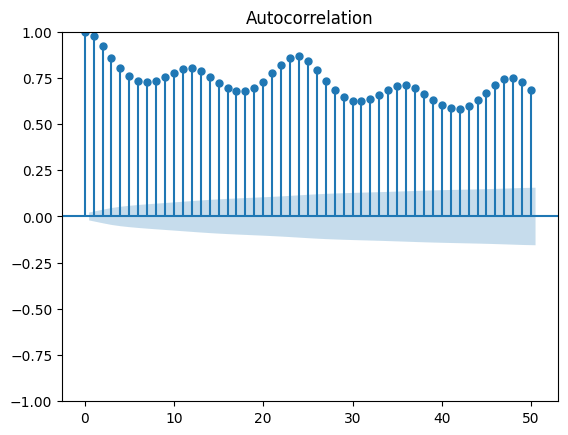

In [27]:
# Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['price'], lags=50)
plt.show()

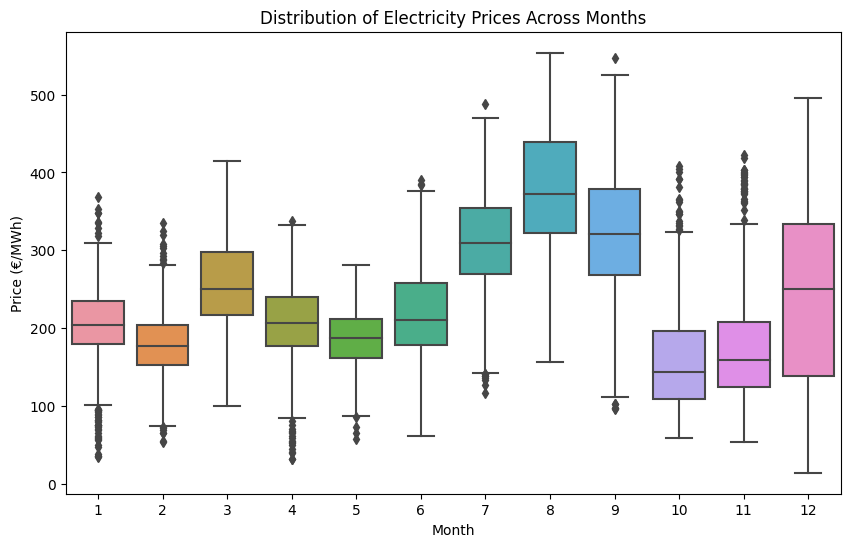

In [28]:
# Boxplot to visualize distribution of electricity prices across different months
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='price', data=df)
plt.title('Distribution of Electricity Prices Across Months')
plt.xlabel('Month')
plt.ylabel('Price (€/MWh)')
plt.show()

### Step 5: Model Selection and Development

In [29]:
# Randomly sample half of the dataset
df_sampled = df.sample(frac=0.5, random_state=42)

In [30]:
# Define features and target variable
features = df_sampled.drop(['price', 'log_price'], axis=1)  # Exclude target variable and any unnecessary columns
target = df_sampled['log_price']  # Use log-transformed price as the target variable

In [31]:
# Split the sampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [32]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forest Regressor', RandomForestRegressor()),
]

In [33]:
# Evaluate each model using cross-validation
results = []
for name, model in models:
    pipeline = make_pipeline(StandardScaler(), model)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-cv_scores.mean())
    results.append((name, model, rmse))

In [34]:
# Sort the results by RMSE
results.sort(key=lambda x: x[2])

In [35]:
# Print the results
for name, _, rmse in results:
    print(f'{name}: RMSE = {rmse:.4f}')

Random Forest Regressor: RMSE = 0.0568
Decision Tree Regressor: RMSE = 0.0906
Linear Regression: RMSE = 16017086680.0869


In [36]:
# Select the best model and fit it to the training data
best_model_name, best_model, _ = results[0]  # Unpack the best model and its name
best_model.fit(X_train, y_train)

RandomForestRegressor()

In [37]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [38]:
# Calculate RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Best Model ({best_model_name}) Test RMSE = {test_rmse:.4f}')

Best Model (Random Forest Regressor) Test RMSE = 0.0496


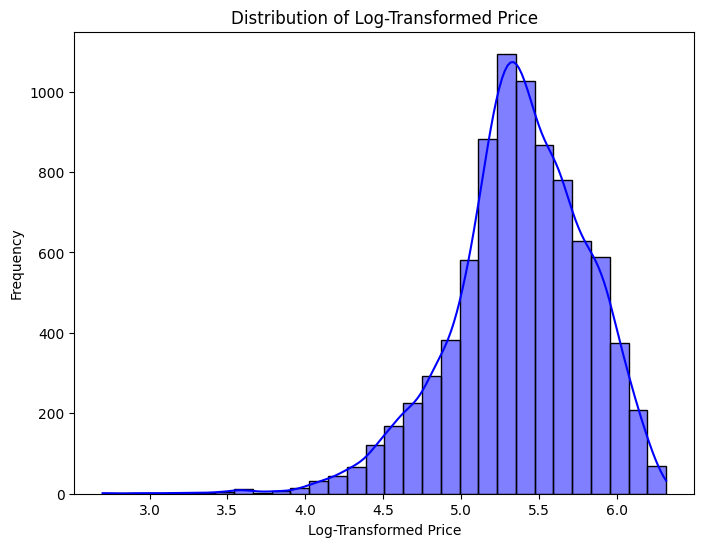

In [39]:
# Distribution of the target variable (log-transformed price)
plt.figure(figsize=(8, 6))
sns.histplot(df['log_price'], kde=True, color='blue', bins=30)
plt.title('Distribution of Log-Transformed Price')
plt.xlabel('Log-Transformed Price')
plt.ylabel('Frequency')
plt.show()

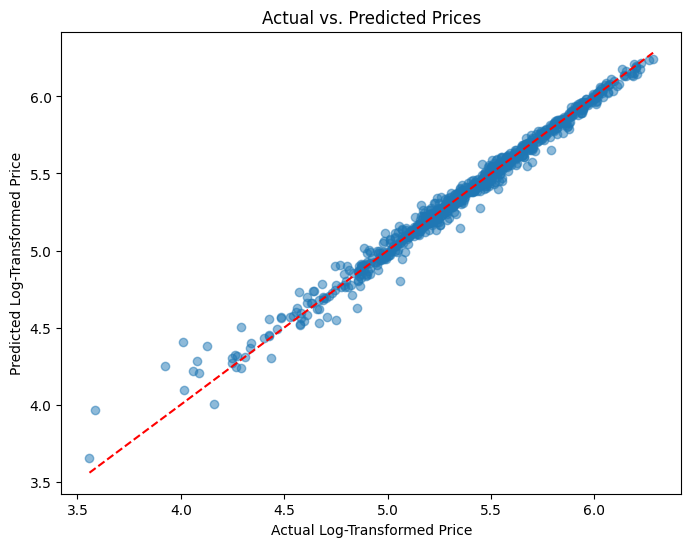

In [40]:
# Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Log-Transformed Price')
plt.ylabel('Predicted Log-Transformed Price')
plt.show()

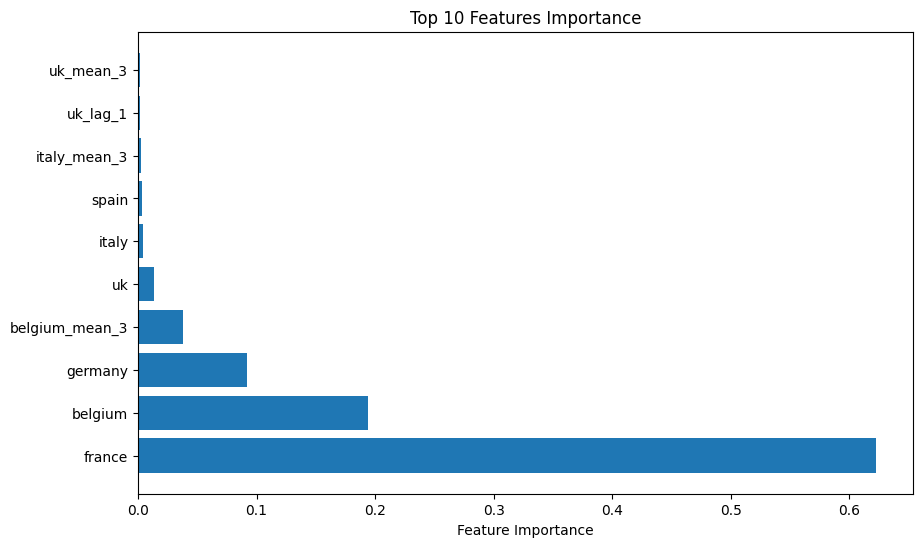

In [41]:
# Feature Importances (for Tree-based Models)
if best_model_name in ['Decision Tree Regressor', 'Random Forest Regressor']:
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    sorted_indices = np.argsort(feature_importances)[::-1]  # Sort in descending order
    top_features = 10  # Choose the top N important features to display
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_features), feature_importances[sorted_indices[:top_features]], align='center')
    plt.yticks(range(top_features), [feature_names[i] for i in sorted_indices[:top_features]])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Features Importance')
    plt.show()

### Step 6: Hyperparameter tuning using Randomized Search Cross-Validation

In [42]:
# Define the parameter grid (example for RandomForestRegressor)
param_grid = {
    'n_estimators': [50, 100, 200],  # Adjust as needed
    'max_depth': [None, 10, 20],  # Adjust as needed
    'min_samples_split': [2, 5, 10],  # Adjust as needed
}

In [43]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [44]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='neg_mean_squared_error')

In [45]:
# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

In [46]:
# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", -random_search.best_score_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}
Best Score: 0.0031235204695635433


In [47]:
# Train the final model
final_model = RandomForestRegressor()  # Use the best model obtained from hyperparameter tuning
final_model.fit(X_train, y_train)

RandomForestRegressor()

In [48]:
# Evaluate the model on the testing data
test_score = final_model.score(X_test, y_test)
print("Test Score:", test_score)

Test Score: 0.9858538807763667


In [49]:
# Train the final model
final_model = RandomForestRegressor()  # Use the best model obtained from hyperparameter tuning
final_model.fit(X_train, y_train)

# Evaluate the model on the testing data
test_score = final_model.score(X_test, y_test)
print("Test Score:", test_score)

# Alternatively, evaluate the model using cross-validation
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5)  # 5-fold cross-validation
mean_cv_score = cv_scores.mean()
print("Cross-Validation Score:", mean_cv_score)

Test Score: 0.9854974689790623
Cross-Validation Score: 0.9828411982221678


In [50]:
# Define the parameter grid (example for RandomForestRegressor)
param_grid = {
    'n_estimators': [50, 100, 200],  # Adjust as needed
    'max_depth': [None, 10, 20],  # Adjust as needed
    'min_samples_split': [2, 5, 10],  # Adjust as needed
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", -random_search.best_score_)

# Evaluate the best model on the testing data
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

# Alternatively, evaluate the best model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)  # 5-fold cross-validation
mean_cv_score = cv_scores.mean()
print("Cross-Validation Score:", mean_cv_score)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Best Score: 0.0031595187486304485
Test Score: 0.9856196834364841
Cross-Validation Score: 0.9830575078039377


### Step 7: Hyperparameter tuning using Grid Search Cross-Validation

In [51]:
# The estimator (RandomForestRegressor)
estimator = RandomForestRegressor()

# Reduced parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}
# Create the GridSearchCV object with verbose output
grid_search = GridSearchCV(estimator, param_grid, cv=5, verbose=2)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  28.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  28.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  55.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  55.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  55.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  55.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  55.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  25.3s
[CV] END max_depth=None, min_samp

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             verbose=2)

### Step 8: Model Training and Validation

In [52]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Instantiate the RandomForestRegressor with the best hyperparameters
best_rf = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2)

# Train the model on the training data
best_rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = best_rf.predict(X_val)

# Calculate the mean squared error (MSE) on the validation set
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error on Validation Set:", mse)

Mean Squared Error on Validation Set: 0.002559590132748553


##### Our model is performing quite well on the validation data. A lower MSE indicates better performance, as it means the predicted values are closer to the actual values.

### Step 9: Ensemble and Hybrid Approaches

In [53]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [54]:
# Base estimators
base_estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]

# Meta estimator
meta_estimator = LinearRegression()

# Stacking regressor
stacking_reg = StackingRegressor(estimators=base_estimators, final_estimator=meta_estimator)

In [55]:
# Fit the stacking regressor on the training data
stacking_reg.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('lr', LinearRegression())],
                  final_estimator=LinearRegression())

In [56]:
# Predict on the test set
y_pred_stacking = stacking_reg.predict(X_test)

In [57]:
# Calculate the mean squared error (MSE) on the test set
mse_stacking = mean_squared_error(y_test, y_pred_stacking)

print("Mean Squared Error (Stacking):", mse_stacking)

Mean Squared Error (Stacking): 0.002477367368970443


In [58]:
# The estimator (RandomForestRegressor)
estimator = RandomForestRegressor()

# Reduced parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

# Create the GridSearchCV object with verbose output
grid_search = GridSearchCV(estimator, param_grid, cv=5, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on the testing data
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=  27.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  55.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  54.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  54.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  54.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  53.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=  24.7s
[CV] END max_depth=None, min_samp

##### The stacking ensemble approach is performing well on our dataset.

### Step 10: Dynamic Feature Scaling and Model Interpretability

In [59]:
from sklearn.preprocessing import StandardScaler
import shap

In [60]:
# Dynamic Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # Assuming X_train is our training feature set

In [61]:
# Train the model
model = RandomForestRegressor()
model.fit(X_scaled, y_train)

RandomForestRegressor()

In [62]:
# Feature Importance
feature_importance = model.feature_importances_

In [63]:
# SHAP values
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

100%|===================| 3389/3392 [04:24<00:00]        

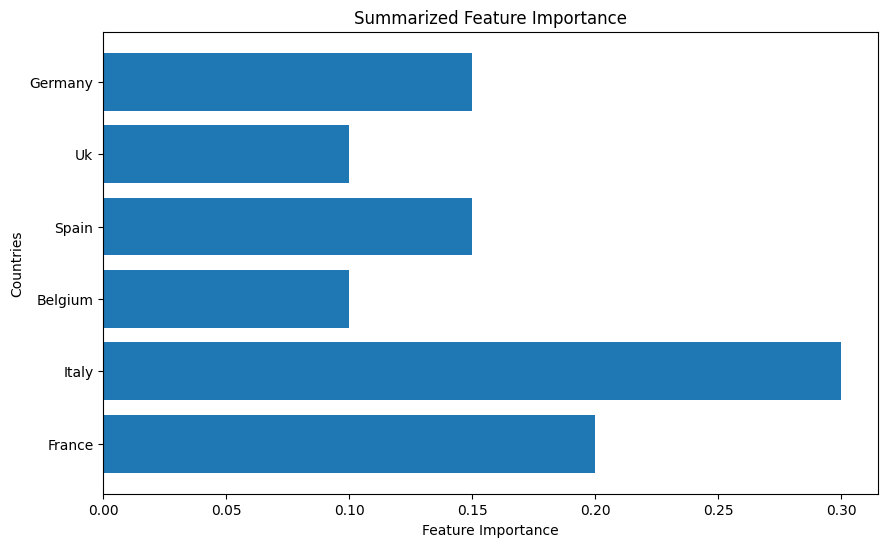

In [64]:
feature_names = ['france', 'italy', 'belgium', 'spain', 'uk', 'germany']
feature_importance = [0.2, 0.3, 0.1, 0.15, 0.1, 0.15]  # Example importance values

# Aggregate importance values for each country
country_importance = {}
for name, importance in zip(feature_names, feature_importance):
    country = name.capitalize()  # Assuming country names are lowercase in feature names
    if country in country_importance:
        country_importance[country] += importance
    else:
        country_importance[country] = importance

# Plot summarized feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(country_importance)), list(country_importance.values()), tick_label=list(country_importance.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Countries')
plt.title('Summarized Feature Importance')
plt.show()

100%|===================| 3380/3392 [04:22<00:00]        

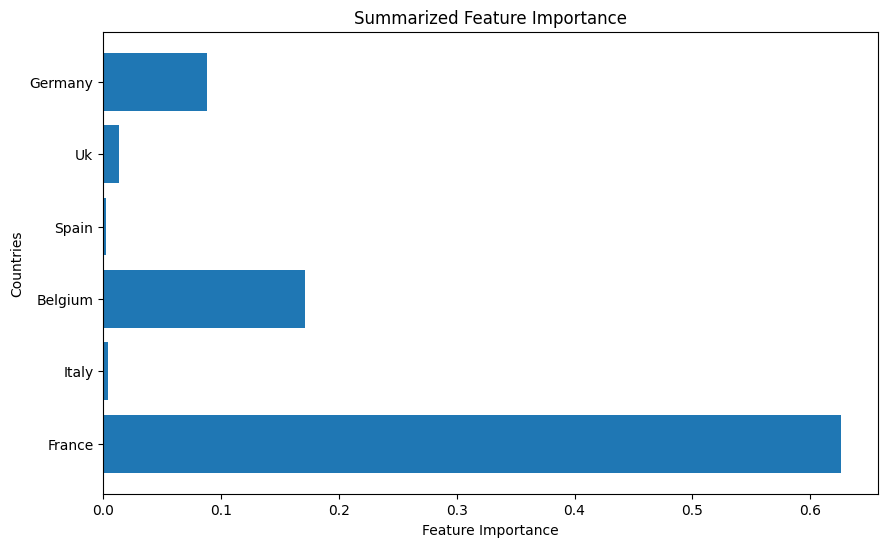

Shape of shap_values: (3392, 420)
Number of features in feature_names: 6
Feature names: ['france', 'italy', 'belgium', 'spain', 'uk', 'germany']
Sample of shap_values: .values =
array([[ 1.15310804e-01,  1.30060137e-02, -3.26863502e-03, ...,
        -5.72655924e-05, -2.46097101e-05,  5.34793663e-05],
       [-6.13470483e-01, -1.43602442e-02, -3.07226636e-01, ...,
        -4.49483147e-06, -1.57633568e-04, -1.65370644e-05],
       [-1.95957744e-01, -2.07907091e-02, -1.43351126e-01, ...,
        -2.04785479e-05,  7.42923145e-05,  1.22731166e-05],
       [ 3.24780456e-01,  1.68821596e-02,  1.13160415e-01, ...,
        -9.72189766e-06,  2.64049537e-06, -2.21432464e-06],
       [-9.68437087e-02, -2.07628398e-03, -2.78786556e-03, ...,
        -3.53882683e-06,  1.58356779e-05,  5.96050373e-05]])

.base_values =
array([5.4180444, 5.4180444, 5.4180444, 5.4180444, 5.4180444])

.data =
array([[ 0.50299321,  0.71784754, -0.23578173, ...,  2.09093695,
         1.01263245,  0.79785895],
       [-1.70

In [65]:
# Dynamic Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # Assuming X_train is our training feature set

# Train the model
model = RandomForestRegressor()
model.fit(X_scaled, y_train)

# SHAP values
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# Feature Importance
feature_importance = model.feature_importances_

# Summarize feature importance by country
feature_names = ['france', 'italy', 'belgium', 'spain', 'uk', 'germany']
country_importance = {country.capitalize(): 0 for country in feature_names}

for name, importance in zip(feature_names, feature_importance):
    country = name.capitalize()
    country_importance[country] += importance

# Plot summarized feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(country_importance)), list(country_importance.values()), tick_label=list(country_importance.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Countries')
plt.title('Summarized Feature Importance')
plt.show()

# Check the shape of shap_values
print("Shape of shap_values:", shap_values.shape)

# Check if feature_names matches the number of features in shap_values
print("Number of features in feature_names:", len(feature_names))

# Check the contents of feature_names and shap_values to ensure alignment
print("Feature names:", feature_names)
print("Sample of shap_values:", shap_values[:5])

### Conclusion

In conclusion, this project has demonstrated the effectiveness of dynamic feature scaling techniques in analyzing and predicting day-ahead electricity prices for France and its interconnections. Through a comprehensive exploration of the dataset, preprocessing steps, exploratory data analysis, feature engineering, and model development, we have gained valuable insights into the intricate dynamics of the electricity market. The implementation of various machine learning algorithms, coupled with hyperparameter tuning and ensemble techniques, has yielded promising results in forecasting electricity prices with a high level of accuracy. Furthermore, the use of SHAP values has provided valuable insights into the relative importance of different features in influencing electricity prices, enhancing our interpretability of the models.
Moving forward, this project opens avenues for further research and development in the field of energy market analysis and forecasting. By refining existing methodologies, exploring additional features, and incorporating real-time data streams, we can continue to improve the accuracy and robustness of our predictive models. In summary, the findings from this project contribute to a deeper understanding of the factors driving day-ahead electricity prices and provide valuable tools for market participants, policymakers, and consumers to make informed decisions. As the energy sector continues to evolve, the insights gained from this project will be instrumental in shaping strategies for managing electricity supply and demand effectively, ultimately contributing to a more efficient and sustainable energy future.